# **Machine Learning application in Market Price Prediction**
#### Name:  Rishabb Suresh

## **Objective**
+ Construct Machine Learning models that use features derived from market observables, to predict price direction in future periods
+ Assess the models using 10-sec as well as 1-min aggregation periods

## **Data Set**
SPY is an Exchange Traded Fund (ETF) that replicates the S&P 500 index, and trades in exchanges like ordinary equity. For all trading days in June 2018, data is aggregated in 10-sec intervals using trading activity in SPY across all exchanges. Each row corresponds to a specific 10-sec interval for the corresponding trading day. Regular trading hours in the US are from 09:30 to 16:00.  

The table below explains feature description in the raw data

|Column              | Description  |
---------------------|--------------|
|volume              | Number of shares traded within the interval  ($\sum_i V_i $,   summing over all trades $i$)          |
|vwap                | Volume Weighted Average Price ( $VWAP = \sum_i V_i P_i / \sum_i V_i$,   summing over all trades $i$) |
|lowPx/highPx        | Lowest and highest trade prices within the interval                               |
|lastBidPx/lastAskPx | Last bid and ask price in the interval                         |
|lastBidSz/lastAskSz | Last bid and ask sizes (in hundreds of shares) in the interval |


## **Feature Engineering**

Derived quantities of interest are

1. The Close Location Value (CLV) indicator. This is an intraday adaptation of a classic technical indicator. It is defined as  
$$
CLV_t = \frac{VWAP_t - (lowPx_t + highPx_t)/2}{(highPx_t - lowPx_t)/2}
$$
It measures the location of the VWAP within interval $t$, relative to the mid-point price between low and high price.  

2. The last *quote imbalance* of interval $t$, defined as 
$$
Imbal_t = \frac{lastBidSz_t - lastAskSz_t}{lastBidSz_t + lastAskSz_t}
$$
By construction $-1 \le Imbal \le 1$.  
When $Imbal \rightarrow 1$, there is much more interest to buy than to sell. 
Conversely, when $Imbal \rightarrow -1$ there is much more interest to sell than to buy.  

3. The log-transformed volume defined as $logVolume = log10(Volume)$  
When working with volume-like quantities (non-negative) taking logs is a common normalization.  

We are also interested in the $N$-period forward return in basis points
$$
\mathrm{fwdRetNBps}_t = 10000 * \left(\frac{VWAP_{t+N}}{VWAP_t} - 1\right)
$$
which helps in calculation of price direction i.e target variable

# **Solution**

## <font color=Blue>Import Modules

In [261]:
#Importing packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Model pre-cursor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from scipy.stats import multinomial
from scipy.stats.stats import pearsonr

#For running model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#For model metrices
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve,fbeta_score,roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#Neural Net
from keras.datasets import mnist
from keras.utils import to_categorical,np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping

## <font color=Blue>Import Data

In [262]:
ROOT = "C:/Users/rishabb/Downloads/MS_ML/Data"
spy_df=pd.read_csv(os.path.join(ROOT,"spy-10sec-201806.csv"))

## <font color=Blue>Data Preparation

##### <font color=Orange>Snapshot of raw data

In [263]:
spy_df.head()

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
0,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100
1,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50
2,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7
3,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20
4,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13


##### <font color=Orange>Feature Engineering

In [264]:
def feat_engg(input_dataset):
    """
    Feature Engineering: Creating new features using exosting features
    
    """
        
    #Removing column that are not required
    output_dataset=input_dataset.drop('sym', axis=1)

    #CLV
    output_dataset['CLV'] = 0
    output_dataset.loc[output_dataset['highPx'] != output_dataset['lowPx'], 'CLV'] = 2*(output_dataset['vwap']-(output_dataset['lowPx']+output_dataset['highPx'])/2)/(output_dataset['highPx']-output_dataset['lowPx'])

    #Imbal
    output_dataset['Imbal'] = (output_dataset['lastBidSz']-output_dataset['lastAskSz'])/(output_dataset['lastBidSz']+output_dataset['lastAskSz'])

    #LogVolume
    output_dataset['logVolume']=np.log10(spy_df['volume'])

    #Forward N day Returns
    output_dataset['fwdRetNBps']=10000*(output_dataset['vwap'].shift(-1)/output_dataset['vwap'] - 1)

    #Drop 1st row
    output_dataset=output_dataset.dropna()
    
    #Additional variable: 60 seconds moving average for 10 seconds data, 6 minute moving average for 1 minute data 
    #Rolling mean is constructed only using past return, current return is not considered in calculation
    output_dataset['rollingmean']=output_dataset['fwdRetNBps'].rolling(window=6).mean().shift(1)
    output_dataset=output_dataset.dropna()
    
    return output_dataset

##### <font color=Orange>Splitting data train/test

In [265]:
def split_10s(dataset_10s):
    """
    Splitting 10 second data into train and test
    
    """
    
    spy_10s_train=dataset_10s.loc[dataset_10s['date']<='2018-06-22']
    spy_10s_test=dataset_10s.loc[dataset_10s['date']>'2018-06-22']   
    
    return spy_10s_train,spy_10s_test

def split_1m(dataset_1m):
    """
    Splitting 1 minute data into train and test
    
    """    
    spy_1m_train=dataset_1m.loc[dataset_1m['date']<='2018-06-22']
    spy_1m_test=dataset_1m.loc[dataset_1m['date']>'2018-06-22']
    
    return spy_1m_train,spy_1m_test

##### <font color=Orange>Creating target

In [266]:
def targetvar(data):
    """
    Creates target variable
    
    """    
    #Average VWAP of train data (same for 10 seconds and 1 minute data)
    RefPx_temp=spy_10s_train['vwap']*spy_10s_train['volume']
    RefPx=RefPx_temp.sum()/spy_10s_train['volume'].sum()

    #Cut-off return in bps
    cutRetBps=10000*.02/RefPx

    #Price Direction
    data['pxDir1'] = 0
    data.loc[ data['fwdRetNBps'] > cutRetBps, 'pxDir1'] = 1
    data.loc[ data['fwdRetNBps'] < (-1*cutRetBps), 'pxDir1'] = -1
    return data

### <font color=Magenta>**10 seconds Data Preparation**

In [267]:
spy_10s=feat_engg(spy_df) #Feature Engineering
spy_10s_train,spy_10s_test=split_10s(spy_10s) #Splitting into test and train
spy_10s_train=targetvar(spy_10s_train) #Creating target variable in training data
spy_10s_test=targetvar(spy_10s_test) #Creating target variable in testing data

### <font color=Magenta>**1 minute Data Preparation**

In [268]:
#################Creating aggregated data with 1minute steps#####################
spy_1m=spy_df

#Joining date and time column
spy_1m['datetime'] = pd.to_datetime(spy_1m['date']+' '+spy_1m['time'])

#Setting seconds as 0
spy_1m['datetime'] = spy_1m['datetime'].apply(lambda t: t.replace(second=0))

#Creating sumproduct of volume and vwap
spy_1m['sumproduct']=spy_1m['volume']*spy_1m['vwap']

#Aggregating data by datetime
spy_1m=spy_1m.groupby(spy_1m['datetime'],as_index=False).agg({'date':'first',
                                                              'time':'first',
                                                              'sym':'first',
                                                              'volume':'sum',
                                                              'sumproduct':'sum',
                                                              'lowPx':'min',
                                                              'highPx':'max',
                                                              'lastBidPx':'last',
                                                              'lastAskPx':'last',
                                                              'lastBidSz':'last',
                                                              'lastAskSz':'last'
                                                            })

#Creating vwap for 1 minute data
spy_1m['vwap']=spy_1m['sumproduct']/spy_1m['volume']
spy_1m=spy_1m.drop('sumproduct', axis=1)

spy_1m=feat_engg(spy_1m) #Feature Engineering
spy_1m_train,spy_1m_test=split_1m(spy_1m) #Splitting into test and train
spy_1m_train=targetvar(spy_1m_train) #Creating target variable in training set
spy_1m_test=targetvar(spy_1m_test) #Creating target variable in testing set

# <font color=Blue>Data Exploration

##### <font color=Orange> Price and Return with time

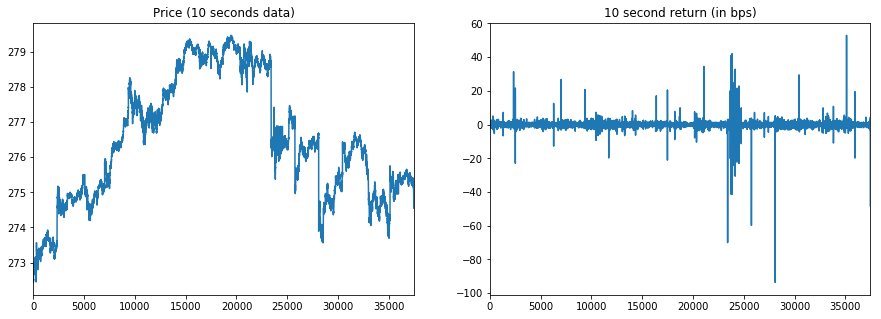

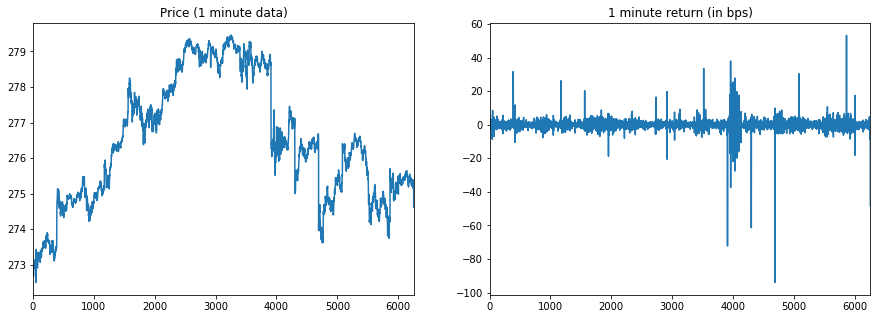

In [269]:
#Plot Price and Returns
fig1 = plt.figure(figsize=(15,5))

ax1 = fig1.add_subplot(121)
spy_10s_train['vwap'].plot(title='Price (10 seconds data)',ax=ax1)
ax2 = fig1.add_subplot(122)
spy_10s_train['fwdRetNBps'].plot(title='10 second return (in bps)',ax=ax2)

fig2 = plt.figure(figsize=(15,5))
ax3 = fig2.add_subplot(121)
spy_1m_train['vwap'].plot(title='Price (1 minute data)',ax=ax3)
ax4 = fig2.add_subplot(122)
spy_1m_train['fwdRetNBps'].plot(title='1 minute return (in bps)',ax=ax4)

##### <font color=Orange> **Univariate distribution for features and targets**

In [270]:
def univardist(parameter,dataset):
    """
    Plot/print the distribution of Parameters
    
    Input
    ----------
    parameter: List of variables for which distribution needs to be generated (i.e., column names)
    dataset: DataFrame
    
    Output
    ----------
    Give univariate distribution of parameter
    """
    for i, j in enumerate(parameter):
        dataset[j].hist(bins=30, density=True, stacked=True)
        dataset[j].plot(kind='density')

        plt.xlim(dataset[j].min(),dataset[j].max())
        plt.xlabel(j)
        plt.show()

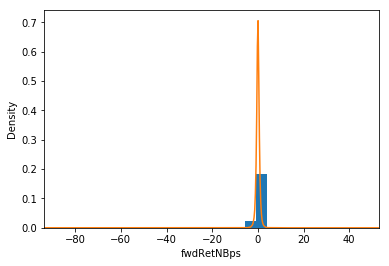

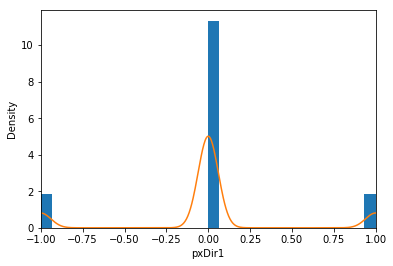

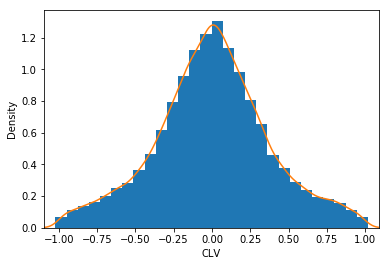

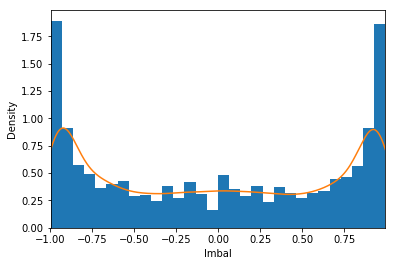

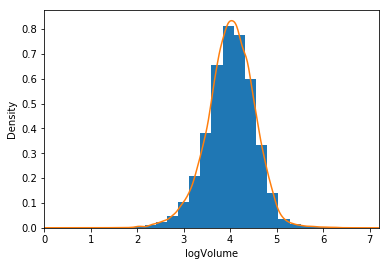

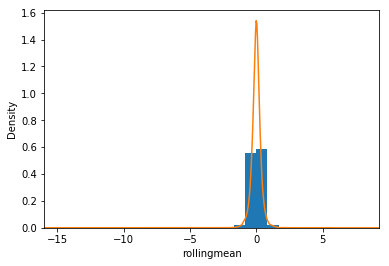

In [271]:
univardist(['fwdRetNBps','pxDir1','CLV','Imbal','logVolume','rollingmean'],spy_10s_train)

##### <font color=Orange> Plot Target vs Numeric Parameters

In [272]:
def bar_num(parameter,target,dataset,bins):
    """
    Plot/print the distribution of Numerican Parameters with respect to target
    
    Input
    ----------
    parameter: List of attributes (i.e., column names)
    target: y-axis for all the plots
    dataset: DataFrame
    bins: Number of bins 
    
    Output
    ----------
    Give bar plot for each numerical parameter vs Target variable 
    """

    for i, j in enumerate(parameter):
        dataset['bin_parameter']=pd.qcut(dataset[j], bins)
        Pricedir_avg=dataset.groupby('bin_parameter').agg({target:'mean'})
        sns.barplot(x=Pricedir_avg.index,y=target,data=Pricedir_avg)
        plt.xticks(rotation=90),plt.xlabel(j)
        plt.show()
        dataset.drop('bin_parameter', axis=1,inplace=True)


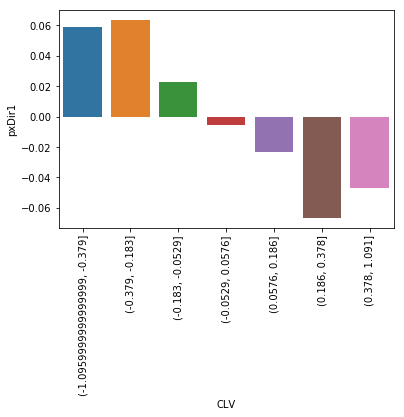

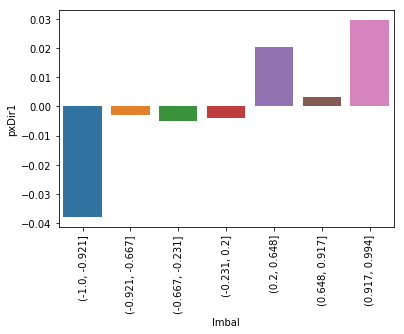

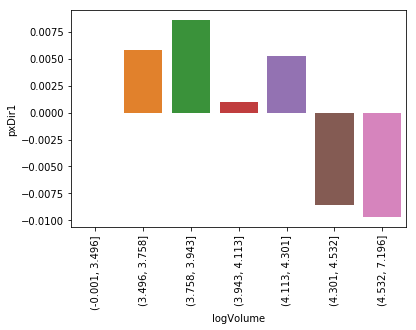

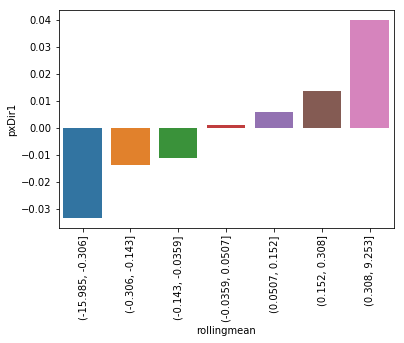

In [273]:
bar_num(['CLV','Imbal','logVolume','rollingmean'],'pxDir1',spy_10s_train,7)

##### <font color=Orange>Summary of Numeric parameters

In [274]:
spy_10s_train.describe()

,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,CLV,Imbal,logVolume,fwdRetNBps,rollingmean,pxDir1
count,3.744500e+04,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000,37445.000000
mean,2.159809e+04,276.464183,276.446811,276.481050,276.458909,276.469080,36.043450,37.526372,0.001416,-0.009667,4.011916,0.001059,0.002230,0.000320
std,1.029641e+05,1.753937,1.755774,1.752598,1.753911,1.753892,50.298034,72.590737,0.374139,0.715465,0.513593,1.401686,0.504273,0.494279
min,1.000000e+00,272.432679,269.019989,272.456696,272.410004,272.420013,1.000000,1.000000,-1.095301,-0.999203,0.000000,-93.624521,-15.983735,-1.000000
25%,5.062000e+03,275.002269,274.989990,275.019989,275.000000,275.010010,4.000000,4.000000,-0.222949,-0.741935,3.704322,-0.366217,-0.174053,0.000000
50%,1.066900e+04,276.306153,276.290009,276.320007,276.299988,276.309998,11.000000,11.000000,0.001145,0.000000,4.028124,0.005328,0.006081,0.000000
75%,2.243800e+04,278.180131,278.160004,278.200012,278.179993,278.190002,50.000000,44.000000,0.226241,0.739130,4.350984,0.380932,0.182024,0.000000
max,1.570653e+07,279.471895,279.459991,279.480011,279.470001,279.480011,1825.000000,2508.000000,1.090909,0.993884,7.196080,52.963310,9.253111,1.000000


##### <font color=Orange>**Correlation Heat Map**

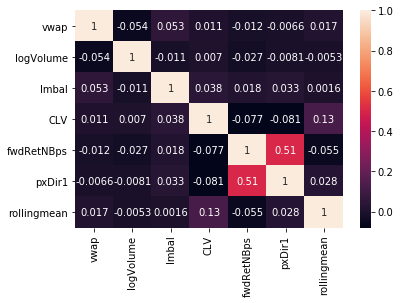

In [275]:
fig1=sns.heatmap(spy_10s_train.loc[:,attr].corr(), annot=True)

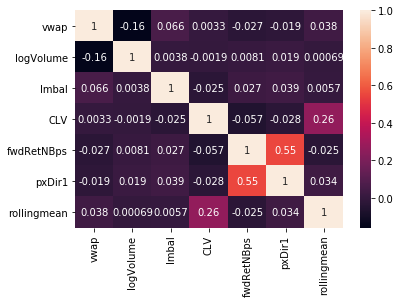

In [276]:
fig2=sns.heatmap(spy_1m_train.loc[:,attr].corr(), annot=True)

##### <font color=Orange>**Rolling Mean vs Actual Return**

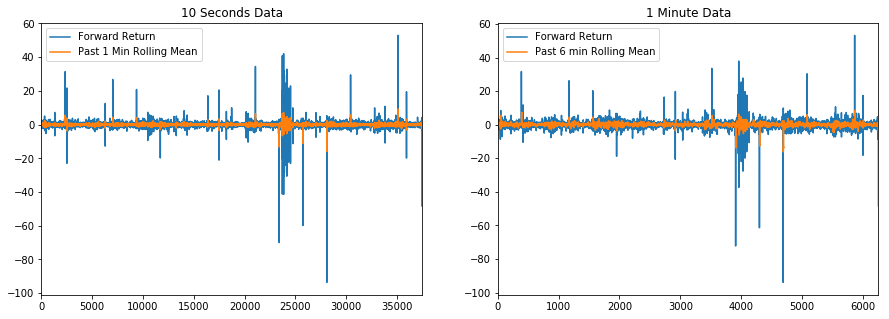

In [277]:
#Plot for 10 sec data
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(121)
spy_10s_train['fwdRetNBps'].plot(title='10 Seconds Data',label='Forward Return',ax=ax1)
spy_10s_train['rollingmean'].plot(label='Past 1 Min Rolling Mean',ax=ax1)
ax1.legend()

#Plot for 1 minute data
ax2 = fig1.add_subplot(122)
spy_1m_train['fwdRetNBps'].plot(title='1 Minute Data',label='Forward Return',ax=ax2)
spy_1m_train['rollingmean'].plot(label='Past 6 min Rolling Mean',ax=ax2)
ax2.legend()

##### <font color=Orange>Defining dependent(Y_train, Y_test) and independent(X_train, X_test) for the model

In [278]:
def dep_indep(train,test):
    """
    Defines Dependent and Independent Variables for the model
    
    """
    X_train = train[['logVolume','Imbal','CLV','rollingmean']]
    Y_train = train["pxDir1"]
    
    X_test  = test[['logVolume','Imbal','CLV','rollingmean']]
    Y_test = test["pxDir1"]
    
    return X_train,Y_train,X_test,Y_test

## <font color=Green>Conclusion of Data Analysis Section
 - **PDF**:The probability density disribution shows that CLV has platykurtic distribution whereas LogVolume has leptokurtic distribution. Imbal has most of the values in extreme regions, whereas rolling mean is majorly distributed around mean of distrubution. The distribution of price direction shows that majority of target is zero (price goes slightly up or down)
 - **Correlation Map**: The variables used in the model are very weakly correlated with the target variable i.e price direction. The highest correlation is with CLV feature
 - **CLV**: Bar plot of CLV shows that price increases for low CLV values and decreases for high CLV values. It is intuitive as CLV is sensitive to bid ask spread. CLV increases as bid-ask spread decreases, and increases when spread is high
 - **LogVolume**: With increase in value of Log(volume), price in the next step decreases
 - **Imbal**: As imbalance increases, price direction shifts from downward to upward increase. The relationship is prominent when imbalance is close to -1 or 1
 - **Rollingmean**: As rolling mean of past return increases, the probability of price increase increases proving Momemntum theory to be true for S&P500.


# <font color=Blue>Baseline Model

### <font color=Magenta>**Baseline for 10 seconds data**

In [279]:
#Probabilities of price direction in training set
prob_10s = spy_10s_train.groupby('pxDir1').size().div(len(spy_10s_train))
print("Probabilities: \n",prob_10s)
print("Total observation in test data:",len(spy_10s_test))

#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_10s_train,spy_10s_test)

#Creating predicted variable using sampling from multinomial distribution
np.random.seed(12345)
Y_test_pred=np.random.choice([-1,0,1],9363,[prob_10s[-1],prob_10s[0],prob_10s[1]])

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred),precision_score(Y_test,Y_test_pred,average='weighted'),recall_score(Y_test,Y_test_pred,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred,average='weighted'),f1_score(Y_test,Y_test_pred,average='micro')

print('\033[1m'+'-' * 22+ "Baseline Model for 10 seconds data"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m')) 
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Baseline',Accuracy,Precision,Recall,F1wght,F1micro))

Probabilities: 
 pxDir1
-1    0.121992
 0    0.755695
 1    0.122313
dtype: float64
Total observation in test data: 9363
----------------------Baseline Model for 10 seconds data----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Baseline         0.3286         0.3694       0.3286       0.3386       0.3286


### <font color=Magenta>**Baseline for 1 minute data**

In [280]:
#Probabilities of price direction in training set
prob_1m = spy_1m_train.groupby('pxDir1').size().div(len(spy_1m_train))
print("Probabilities: \n",prob_1m)
print("Total observation in test data:",len(spy_1m_test))

#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_1m_train,spy_1m_test)

#Creating predicted variable using sampling from multinomial distribution
np.random.seed(12345)
Y_test_pred=np.random.choice([-1,0,1],1563,[prob_1m[-1],prob_1m[0],prob_1m[1]])

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred),precision_score(Y_test,Y_test_pred,average='weighted'),recall_score(Y_test,Y_test_pred,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred,average='weighted'),f1_score(Y_test,Y_test_pred,average='micro')

print('\033[1m'+'-' * 22+ "Baseline Model for 1 minute data"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Baseline',Accuracy,Precision,Recall,F1wght,F1micro))

Probabilities: 
 pxDir1
-1    0.29424
 0    0.39728
 1    0.30848
dtype: float64
Total observation in test data: 1563
----------------------Baseline Model for 1 minute data----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Baseline         0.3263         0.3474       0.3263       0.3318       0.3263


# <font color=Blue>Model 1 : Logistic Regression

### <font color=Magenta>**Multinomial Logistic for 10 seconds data**

In [281]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_10s_train,spy_10s_test)
X_train=X_train[['logVolume','Imbal','CLV']]
X_test=X_test[['logVolume','Imbal','CLV']]

#Model fitting and prediction
mult_LR = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
Y_train_pred=mult_LR.predict(X_train)
Y_test_pred=mult_LR.predict(X_test)

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred),precision_score(Y_test,Y_test_pred,average='weighted'),recall_score(Y_test,Y_test_pred,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred,average='weighted'),f1_score(Y_test,Y_test_pred,average='micro')

print("Accuracy in train data:",accuracy_score(Y_train,Y_train_pred))
print('\033[1m'+'-' * 22+ "Logistic Regression for 10 seconds data(test data)"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Logistic',Accuracy,Precision,Recall,F1wght,F1micro))

Accuracy in train data: 0.7566831352650554
----------------------Logistic Regression for 10 seconds data(test data)----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Logistic         0.5001         0.4871       0.5001       0.3382       0.5001


### <font color=Magenta>**Multinomial Logistic for 10 seconds data with new variable**

In [282]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_10s_train,spy_10s_test)

#Model fitting and prediction
mult_LR = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
Y_test_pred=mult_LR.predict(X_test)
Y_train_pred=mult_LR.predict(X_train)

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred),precision_score(Y_test,Y_test_pred,average='weighted'),recall_score(Y_test,Y_test_pred,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred,average='weighted'),f1_score(Y_test,Y_test_pred,average='micro')

print("Accuracy in train data:",accuracy_score(Y_train,Y_train_pred))
print('\033[1m'+'-' * 22+ "Logistic Regression for 10 seconds data with new variable (test data)"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Logistic',Accuracy,Precision,Recall,F1wght,F1micro))

Accuracy in train data: 0.7565763119241554
----------------------Logistic Regression for 10 seconds data with new variable (test data)----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Logistic         0.5006         0.4738       0.5006       0.3393       0.5006


### <font color=Magenta>**Multinomial Logistic for 1 minute data**

In [283]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_1m_train,spy_1m_test)
X_train=X_train[['logVolume','Imbal','CLV']]
X_test=X_test[['logVolume','Imbal','CLV']]

#Model fitting and prediction
mult_LR = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
Y_test_pred=mult_LR.predict(X_test)
Y_train_pred=mult_LR.predict(X_train)

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred),precision_score(Y_test,Y_test_pred,average='weighted'),recall_score(Y_test,Y_test_pred,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred,average='weighted'),f1_score(Y_test,Y_test_pred,average='micro')

print("Accuracy in train data:",accuracy_score(Y_train,Y_train_pred))
print('\033[1m'+'-' * 22+ "Logistic Regression for 1 minute data(test data)"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Logistic',Accuracy,Precision,Recall,F1wght,F1micro))

Accuracy in train data: 0.39712
----------------------Logistic Regression for 1 minute data(test data)----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Logistic         0.2182         0.2360       0.2182       0.0802       0.2182


### <font color=Magenta>**Multinomial Logistic for 1 minute data with new variable**

In [284]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_1m_train,spy_1m_test)

#Model fitting and prediction
mult_LR = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
Y_test_pred=mult_LR.predict(X_test)
Y_train_pred=mult_LR.predict(X_train)

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred),precision_score(Y_test,Y_test_pred,average='weighted'),recall_score(Y_test,Y_test_pred,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred,average='weighted'),f1_score(Y_test,Y_test_pred,average='micro')

print("Accuracy in train data:",accuracy_score(Y_train,Y_train_pred))
print('\033[1m'+'-' * 22+ "Logistic Regression for 1 minute data(test data)"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Logistic',Accuracy,Precision,Recall,F1wght,F1micro))

Accuracy in train data: 0.3984
----------------------Logistic Regression for 1 minute data(test data)----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Logistic         0.2265         0.4747       0.2265       0.1006       0.2265


# <font color=Blue>Model 2 : Neural Network

### <font color=Magenta>**NN for 10 seconds data**

In [285]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_10s_train,spy_10s_test)
X_train=X_train[['logVolume','Imbal','CLV']]
X_test=X_test[['logVolume','Imbal','CLV']]

#Parameters
num_classes=3     #classes:(-1,0,1)
drop_rate=.4

#Convert the target values vector to binary class matrix
dummy_Y_train = to_categorical(Y_train, 3)
dummy_Y_test = to_categorical(Y_test, num_classes)

#Creating Layers
NN = Sequential()
NN.add(Dense(20, input_dim=3, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(20,activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(num_classes, activation='softmax'))

# Compile model
NN.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

NN_batch_size = 50
NN_epochs = 10
NN_val_split=.2

# create an early stopping callback
NN_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)
# Fitting the RNN to the Training set
NN_hist=NN.fit(X_train, dummy_Y_train, epochs = NN_epochs,validation_split=NN_val_split,callbacks=[NN_es], batch_size = NN_batch_size,verbose=0)

#Predicted Ys
train_val_score = NN.evaluate(X_train, dummy_Y_train, verbose=0)
test_val_score = NN.evaluate(X_test, dummy_Y_test, verbose=0)

print('Train loss score: {0:.4f}'.format(train_val_score[0]))
print('Train accuracy:   {0:.4f}'.format(train_val_score[1]))
print('Test loss score: {0:.4f}'.format(test_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(test_val_score[1]))

#Predicting price increase/decrease/constant
Y_test_pred_classes=NN.predict_classes(X_test) #Converts probability into prediction
Y_test_pred_classes=pd.Series(Y_test_pred_classes).replace(2,-1) #Replacing class='2' as -1' which is price decrease

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred_classes),precision_score(Y_test,Y_test_pred_classes,average='weighted'),recall_score(Y_test,Y_test_pred_classes,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred_classes,average='weighted'),f1_score(Y_test,Y_test_pred_classes,average='micro')

print('\033[1m' '\n' +'-' * 22+ "Neural Network for 10 seconds data"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Neural Network',Accuracy,Precision,Recall,F1wght,F1micro))

Train loss score: 0.6965
Train accuracy:   0.7557
Test loss score: 1.1386
Test accuracy:   0.4985

----------------------Neural Network for 10 seconds data----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Neural Network       0.4985         0.2485       0.4985       0.3316       0.4985


### <font color=Magenta>**NN for 10 seconds data with new variable**

In [286]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_10s_train,spy_10s_test)

#Parameters
num_classes=3     #classes:(-1,0,1)
drop_rate=.4

#Convert the target values vector to binary class matrix
dummy_Y_train = to_categorical(Y_train, 3)
dummy_Y_test = to_categorical(Y_test, num_classes)

#Creating Layers
NN = Sequential()
NN.add(Dense(20, input_dim=4, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(20,activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(num_classes, activation='softmax'))

# Compile model
NN.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

NN_batch_size = 50
NN_epochs = 10
NN_val_split=.2

# create an early stopping callback
NN_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)
# Fitting the RNN to the Training set
NN_hist=NN.fit(X_train, dummy_Y_train, epochs = NN_epochs,validation_split=NN_val_split,callbacks=[NN_es], batch_size = NN_batch_size,verbose=0)

#Predicted Ys
train_val_score = NN.evaluate(X_train, dummy_Y_train, verbose=0)
test_val_score = NN.evaluate(X_test, dummy_Y_test, verbose=0)

print('Train loss score: {0:.4f}'.format(train_val_score[0]))
print('Train accuracy:   {0:.4f}'.format(train_val_score[1]))
print('Test loss score: {0:.4f}'.format(test_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(test_val_score[1]))

#Predicting price increase/decrease/constant
Y_test_pred_classes=NN.predict_classes(X_test) #Converts probability into prediction
Y_test_pred_classes=pd.Series(Y_test_pred_classes).replace(2,-1) #Replacing class='2' as -1' which is price decrease

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred_classes),precision_score(Y_test,Y_test_pred_classes,average='weighted'),recall_score(Y_test,Y_test_pred_classes,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred_classes,average='weighted'),f1_score(Y_test,Y_test_pred_classes,average='micro')

print('\033[1m' '\n' +'-' * 22+ "Neural Network for 10 seconds data with new variable"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Neural Network',Accuracy,Precision,Recall,F1wght,F1micro))

Train loss score: 0.6869
Train accuracy:   0.7557
Test loss score: 1.0938
Test accuracy:   0.4985

----------------------Neural Network for 10 seconds data with new variable----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Neural Network       0.4985         0.2485       0.4985       0.3316       0.4985


### <font color=Magenta>**NN for 1 minute data**

In [287]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_1m_train,spy_1m_test)
X_train=X_train[['logVolume','Imbal','CLV']]
X_test=X_test[['logVolume','Imbal','CLV']]

#Parameters
num_classes=3     #classes:(-1,0,1)
drop_rate=.4

#Convert the target values vector to binary class matrix
dummy_Y_train = to_categorical(Y_train, 3)
dummy_Y_test = to_categorical(Y_test, num_classes)

#Creating Layers
NN = Sequential()
NN.add(Dense(20, input_dim=3, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(20,activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(num_classes, activation='softmax'))

# Compile model
NN.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

NN_batch_size = 20
NN_epochs = 10
NN_val_split=.1

# create an early stopping callback
NN_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)
# Fitting the RNN to the Training set
NN_hist=NN.fit(X_train, dummy_Y_train, epochs = NN_epochs,validation_split=NN_val_split,callbacks=[NN_es], batch_size = NN_batch_size,verbose=0)

#Predicted Ys
train_val_score = NN.evaluate(X_train, dummy_Y_train, verbose=0)
test_val_score = NN.evaluate(X_test, dummy_Y_test, verbose=0)

print('Train loss score: {0:.4f}'.format(train_val_score[0]))
print('Train accuracy:   {0:.4f}'.format(train_val_score[1]))
print('Test loss score: {0:.4f}'.format(test_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(test_val_score[1]))

#Predicting price increase/decrease/constant
Y_test_pred_classes=NN.predict_classes(X_test) #Converts probability into prediction
Y_test_pred_classes=pd.Series(Y_test_pred_classes).replace(2,-1) #Replacing class='2' as -1' which is price decrease

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred_classes),precision_score(Y_test,Y_test_pred_classes,average='weighted'),recall_score(Y_test,Y_test_pred_classes,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred_classes,average='weighted'),f1_score(Y_test,Y_test_pred_classes,average='micro')

print('\033[1m' '\n' +'-' * 22+ "Neural Network for 1 minute data"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Neural Network',Accuracy,Precision,Recall,F1wght,F1micro))

Train loss score: 1.0892
Train accuracy:   0.3973
Test loss score: 1.1384
Test accuracy:   0.2175

----------------------Neural Network for 1 minute data----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Neural Network       0.2175         0.0473       0.2175       0.0777       0.2175


### <font color=Magenta>**NN for 1 minute data with new variable**

In [288]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(spy_1m_train,spy_1m_test)

#Parameters
num_classes=3     #classes:(-1,0,1)
drop_rate=.4

#Convert the target values vector to binary class matrix
dummy_Y_train = to_categorical(Y_train, 3)
dummy_Y_test = to_categorical(Y_test, num_classes)

#Creating Layers
NN = Sequential()
NN.add(Dense(20, input_dim=4, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(20,activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform'))
NN.add(Dropout(drop_rate))
NN.add(Dense(num_classes, activation='softmax'))

# Compile model
NN.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

NN_batch_size = 50
NN_epochs = 10
NN_val_split=.2

# create an early stopping callback
NN_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)
# Fitting the RNN to the Training set
NN_hist=NN.fit(X_train, dummy_Y_train, epochs = NN_epochs,validation_split=NN_val_split,callbacks=[NN_es], batch_size = NN_batch_size,verbose=0)

#Predicted Ys
train_val_score = NN.evaluate(X_train, dummy_Y_train, verbose=0)
test_val_score = NN.evaluate(X_test, dummy_Y_test, verbose=0)

print('Train loss score: {0:.4f}'.format(train_val_score[0]))
print('Train accuracy:   {0:.4f}'.format(train_val_score[1]))
print('Test loss score: {0:.4f}'.format(test_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(test_val_score[1]))

#Predicting price increase/decrease/constant
Y_test_pred_classes=NN.predict_classes(X_test) #Converts probability into prediction
Y_test_pred_classes=pd.Series(Y_test_pred_classes).replace(2,-1) #Replacing class='2' as -1' which is price decrease

#Metrics
Accuracy,Precision,Recall=accuracy_score(Y_test,Y_test_pred_classes),precision_score(Y_test,Y_test_pred_classes,average='weighted'),recall_score(Y_test,Y_test_pred_classes,average='weighted')
F1wght,F1micro=f1_score(Y_test,Y_test_pred_classes,average='weighted'),f1_score(Y_test,Y_test_pred_classes,average='micro')

print('\033[1m' '\n' +'-' * 22+ "Neural Network for 1 minute data with new variable"+'-' * 22)
print('\n{:<10s}{:>15s}{:>15s}{:>13s}{:>13s}{:>17s}'.format('Model','Accuracy','Precision','Recall','F1wght','F1micro'+'\033[0m'))
print('-' * 80)
print('{:<10s}{:>13.4f}{:>15.4f}{:>13.4f}{:>13.4f}{:>13.4f}'.format('Neural Network',Accuracy,Precision,Recall,F1wght,F1micro))

Train loss score: 1.0829
Train accuracy:   0.4067
Test loss score: 1.1201
Test accuracy:   0.2783

----------------------Neural Network for 1 minute data with new variable----------------------

Model            Accuracy      Precision       Recall       F1wght      F1micro
--------------------------------------------------------------------------------
Neural Network       0.2783         0.4274       0.2783       0.2140       0.2783


# <font color=Blue>Result and Conclusion

 - **Metrics Table for Prediction in Test Data**

|Model|Data|Variable| Accuracy|Precision|Recall|F1wght|F1micro|Accuracy Diff(10sec vs 1min)|Accuracy Diff(Base features vs New feature)
|-----------|-------|--------------|----------------|-------------|------------|----------------|-----------|---------------|----|
|Baseline|10 sec|Base features|0.3286|0.3694|0.3286|0.3386|0.3286|-|
|Baseline|1 min|Base features|0.3263|0.3474|0.3263|0.3318| 0.3263|-0.0033|
|Logistic|10 sec|Base features|0.5001 |0.4871|0.5001|0.3382|0.5001|-|
|Logistic|1 min|Base features|0.2182|0.2360|0.2182|0.0802|0.2182|-0.2819|
|Logistic|10 sec|New feature| 0.5006|0.4738|0.5006|0.3393|0.5006|-|0.0005|
|Logistic|1 min|New feature|0.2265|0.4747|0.2265|0.1006|0.2265|-0.2741|0.0083|
|Neural Net|10 sec|Base features|0.4985|0.2485|0.4985|0.3316|0.4985|-|
|Neural Net|1 min|Base features|0.2175|0.0473|0.2175|0.0777|0.2175|-0.281|
|Neural Net|10 sec|New feature|0.4985|0.3353|0.4985|0.3319|0.4985|-|0|
|Neural Net|1 min|New feature|0.2655|0.3840|0.2655|0.1848|0.2655|-0.233|0.048|

 - **Performance Improvement 10 sec vs 1 min**: From 'Accuracy Diff' column, it can be seen that accuracy of 10 seconds data is better than 1 minute data. We can say that features are more effective in predicting very short range future (next 10 seconds), compared to prediction of next 1 minute direction
 - **Performance Improvement with rollingmean feature**: Accuracy of models improve slightly with addition of new feature, rolling mean. The result of new feature is more prominent in 1 minute data compared to 10 seconds data
 - **Multinomial Logistic Regression**: Accuracy of logistic regression is better than baseline model for 10 seconds data, but for 1 minute data it is worse than baseline model. Precision of model has improved for both 10 seconds data and 1 minute data with new feature
 - **Neural Network**: Accuracy of neural network model is similar to logistic regression model. Precision of model has gone down compared to Baseline model. The use of neural nets with more layers did not help in improving the model. Though, the accuracy in train data was high (~75% for 10 sec and ~40% for 1 min data), the model performed poorly in test data. Use of Dropout feature (40% dropout rate) was also not helpful in avoiding overfitting
 - **Best Model**: Best model for 10 seconds data is Logistic Regression while using rolling mean feature along with base features. 
 Best model for 1 minute data is unfortunately baseline model, which gives a random estimate for price direction.
 - **Conclusion**: The features used in the model are feebly correlated with price direction and there is a need for better features, specially for 1 minute prediction. Also, intra-day market volatility is high compared to inter-day,it gets difficult to predict price direction for such short interval because of noise in data.